In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from itertools import product

In [4]:
data = pd.read_csv("/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv")
print("data shape:", data.shape)
data.head()

data shape: (372450, 785)


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print("\n" + "="*60)
print("DATA CLEANING")
print("="*60)

# Check for missing values
print(f"Missing values before cleaning: {data.isnull().sum().sum()}")

# Remove any rows with missing values
data = data.dropna()
print(f"Missing values after cleaning: {data.isnull().sum().sum()}")

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"Duplicate rows found: {duplicates}")
if duplicates > 0:
    data = data.drop_duplicates()
    print(f"Duplicate rows removed: {duplicates}")

# Check data types
print(f"\nData types:\n{data.dtypes.value_counts()}")

# Check for any invalid pixel values (should be 0-255)
pixel_cols = data.columns[1:]  # All columns except label
invalid_pixels = ((data[pixel_cols] < 0) | (data[pixel_cols] > 255)).sum().sum()
print(f"Invalid pixel values (outside 0-255): {invalid_pixels}")

# Remove rows with invalid pixel values
if invalid_pixels > 0:
    mask = ((data[pixel_cols] >= 0) & (data[pixel_cols] <= 255)).all(axis=1)
    data = data[mask]
    print(f"Rows with invalid pixel values removed")

# Check for empty images (all zeros)
print(f"\nChecking for empty/uniform images...")
empty_images = (data[pixel_cols] == 0).all(axis=1).sum()
print(f"Empty images (all zeros): {empty_images}")
if empty_images > 0:
    data = data[~(data[pixel_cols] == 0).all(axis=1)]
    print(f"Empty images removed: {empty_images}")

# Check for uniform images (no contrast - all pixels same value)
uniform_images = data[pixel_cols].apply(lambda row: row.nunique() == 1, axis=1).sum()
print(f"Uniform images (no contrast): {uniform_images}")
if uniform_images > 0:
    data = data[~data[pixel_cols].apply(lambda row: row.nunique() == 1, axis=1)]
    print(f"Uniform images removed: {uniform_images}")

# Check for very low contrast images (std < 5)
low_contrast = (data[pixel_cols].std(axis=1) < 5).sum()
print(f"Very low contrast images (std < 5): {low_contrast}")
if low_contrast > 0:
    data = data[data[pixel_cols].std(axis=1) >= 5]
    print(f"Low contrast images removed: {low_contrast}")

# Check class distribution
print(f"\nClass distribution:")
print(data["0"].value_counts().sort_index())

# Ensure all classes (0-25) are present
expected_classes = set(range(26))
actual_classes = set(data["0"].unique())
missing_classes = expected_classes - actual_classes
if missing_classes:
    print(f"WARNING: Missing classes: {missing_classes}")
else:
    print("All 26 classes present ✓")

print(f"\nFinal cleaned data shape: {data.shape}")
print("="*60 + "\n")


DATA CLEANING
Missing values before cleaning: 0
Missing values after cleaning: 0
Duplicate rows found: 171355
Duplicate rows removed: 171355

Data types:
int64    785
Name: count, dtype: int64
Invalid pixel values (outside 0-255): 0

Checking for empty/uniform images...
Empty images (all zeros): 0
Uniform images (no contrast): 0
Very low contrast images (std < 5): 0

Class distribution:
0
0      7680
1      4804
2     12170
3      5430
4      6039
5      1147
6      3206
7      3974
8      1061
9      4593
10     3156
11     6226
12    10373
13     9909
14    29306
15    10087
16     3281
17     6170
18    24622
19    11698
20    14921
21     2616
22     5804
23     3557
24     5833
25     3432
Name: count, dtype: int64
All 26 classes present ✓

Final cleaned data shape: (201095, 785)



In [6]:
output = data["0"]
Input = data.drop(labels=["0"], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(Input, output, test_size=0.2, random_state=42, stratify=output)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (160876, 784)
X_test shape: (40219, 784)


In [7]:
Y_train_raw = Y_train.copy()

In [8]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [9]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
print("x_train shape:", X_train.shape)
print("x_test shape:", X_test.shape)

x_train shape: (160876, 28, 28, 1)
x_test shape: (40219, 28, 28, 1)


In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
Y_train = to_categorical(Y_train, num_classes=26)
Y_test = to_categorical(Y_test, num_classes=26)

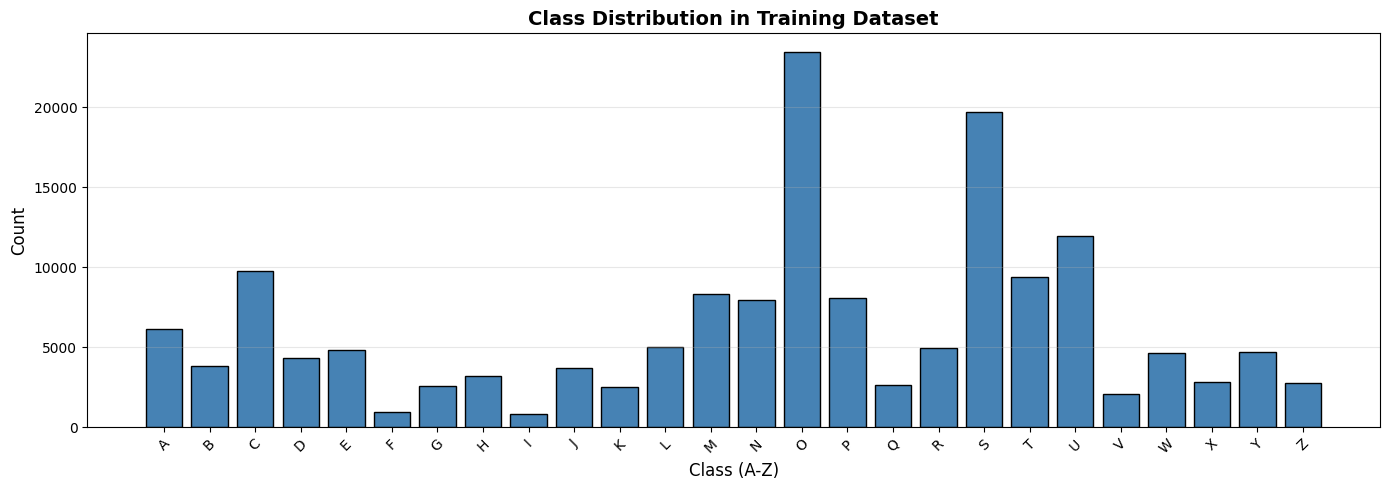

In [12]:
alpha = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
unique, counts = np.unique(Y_train_raw, return_counts=True)
plt.figure(figsize=(14, 5))
plt.bar(alpha, counts, color='steelblue', edgecolor='black')
plt.title('Class Distribution in Training Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Class (A-Z)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [13]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.15, random_state=2, stratify=Y_train.argmax(axis=1))
print("x_train shape", X_train.shape)
print("x_validation shape", X_validation.shape)
print("y_train shape", Y_train.shape)
print("y_validation shape", Y_validation.shape)

x_train shape (136744, 28, 28, 1)
x_validation shape (24132, 28, 28, 1)
y_train shape (136744, 26)
y_validation shape (24132, 26)


In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.12),
    layers.RandomTranslation(0.12, 0.12),
    layers.RandomContrast(0.12)
], name="data_augmentation")

def preprocess_for_vgg(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.image.grayscale_to_rgb(image)
    return image, label

BATCH = 16

train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = (
    train_ds.shuffle(10000)
            .map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
            .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH)
            .prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((X_validation, Y_validation))
val_ds = (
    val_ds.map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH)
          .prefetch(tf.data.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds = (
    test_ds.map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE)
)

print("Training batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

I0000 00:00:1765158589.589228      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Training batches: 8547
Validation batches: 1509
Test batches: 2514



VISUALIZING DATA AUGMENTATION EFFECTS


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

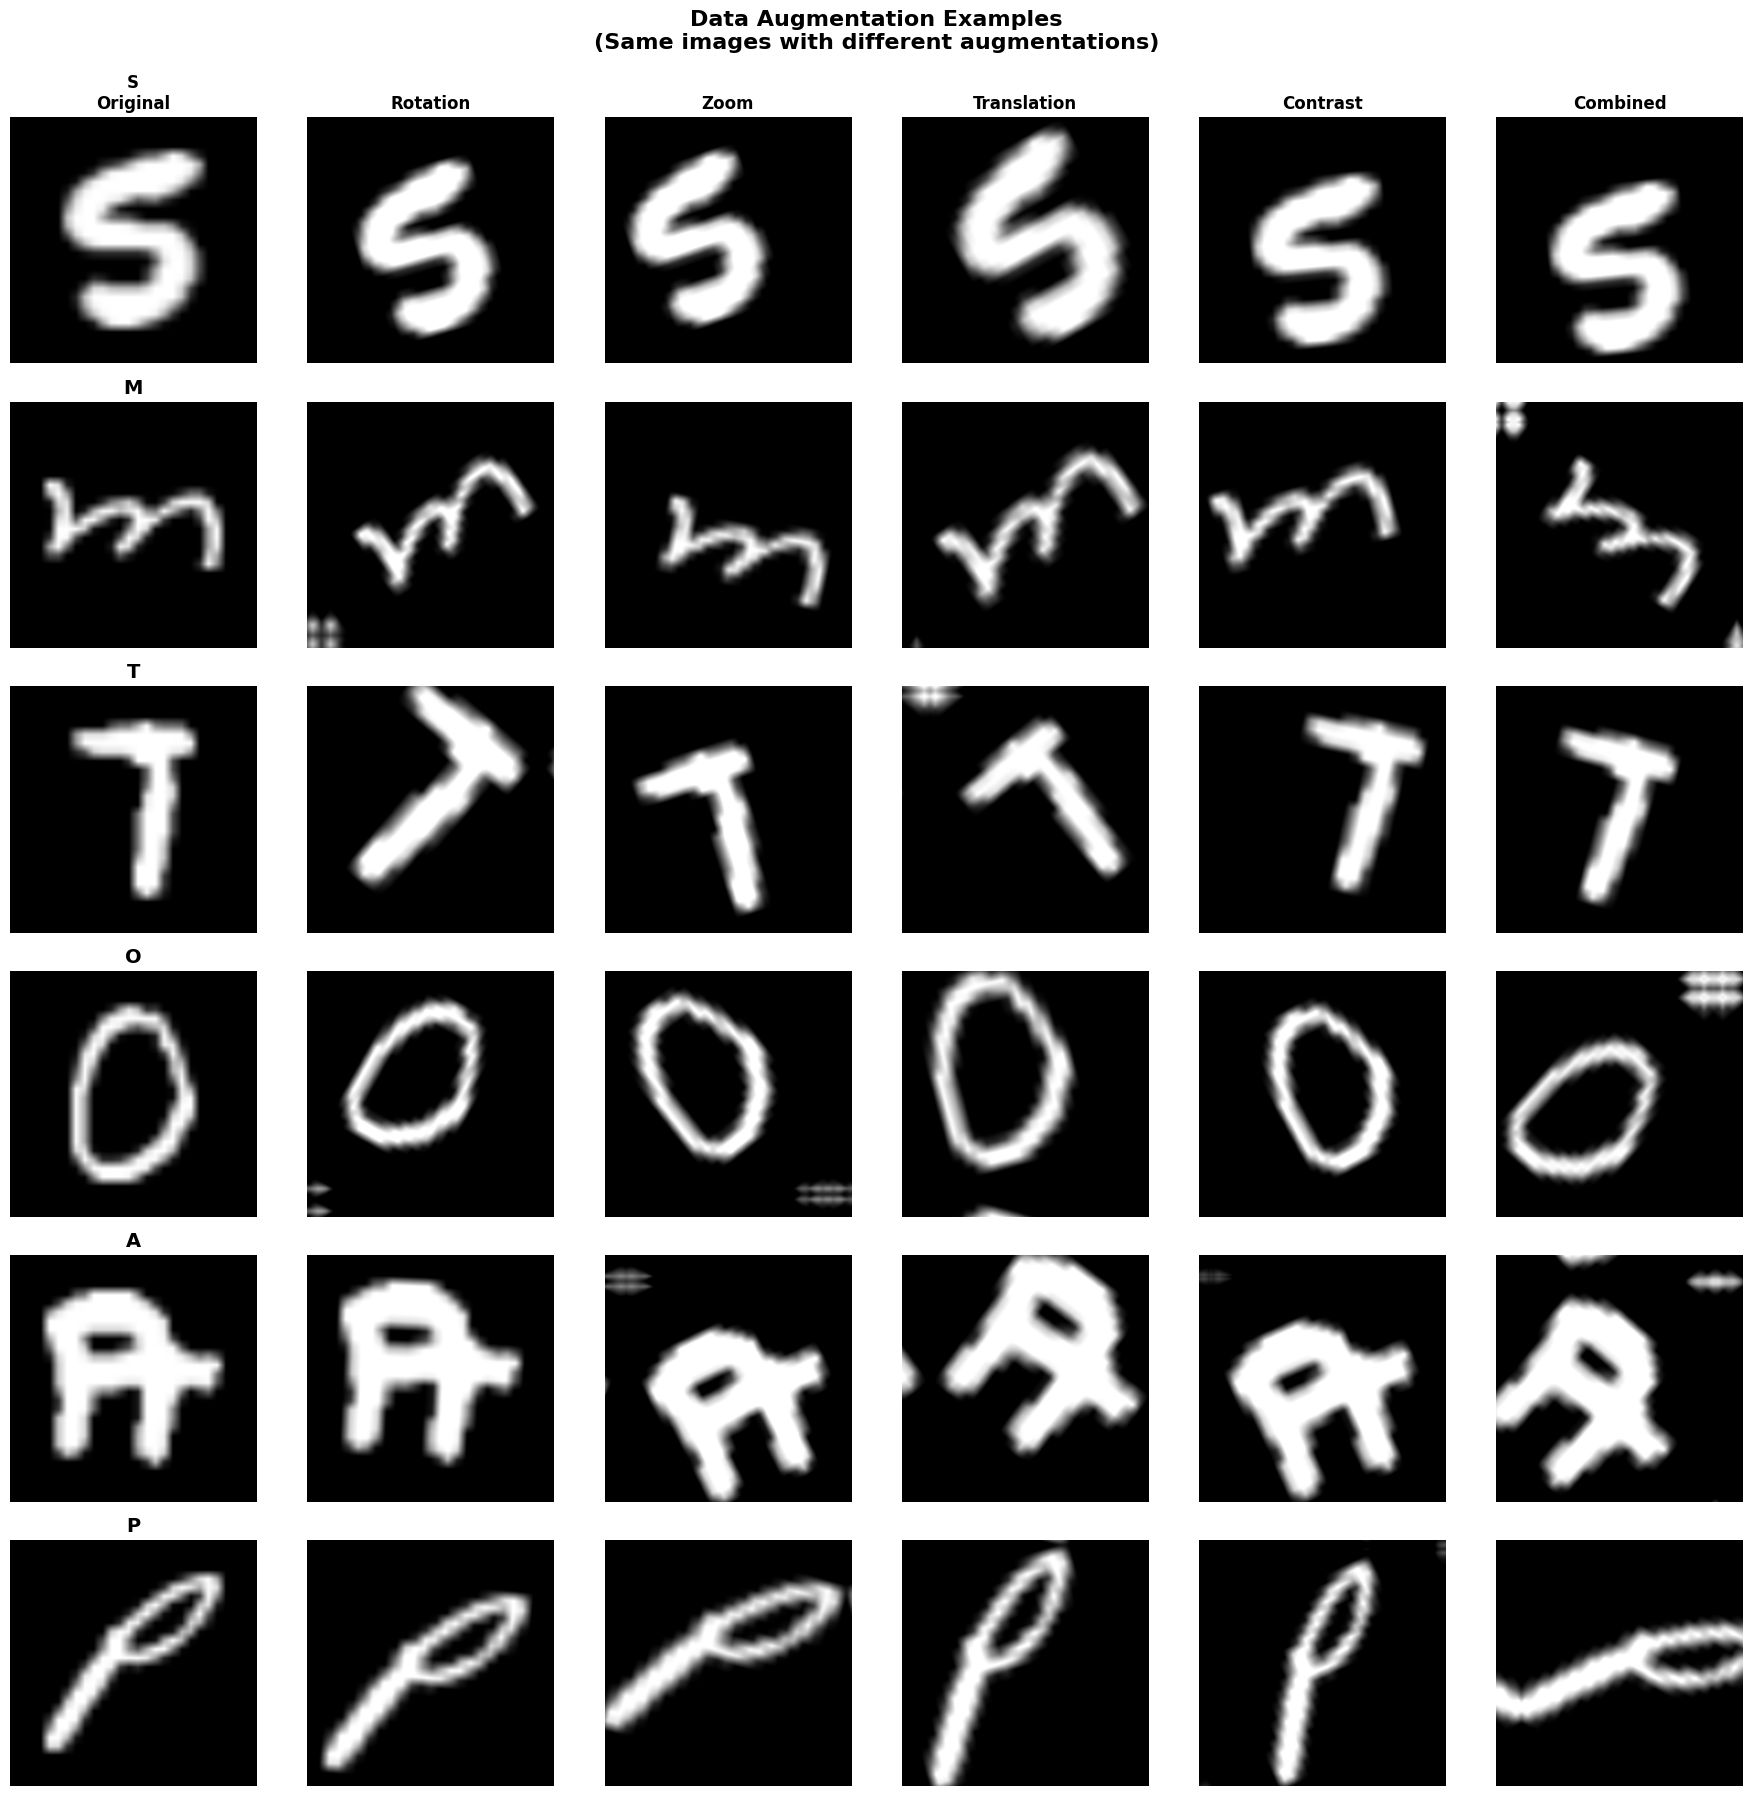

✓ All data pipelines created successfully!



In [15]:
print("\n" + "="*70)
print("VISUALIZING DATA AUGMENTATION EFFECTS")
print("="*70)

# Select random samples from different classes for visualization
np.random.seed(42)
sample_indices = np.random.choice(len(X_train), size=6, replace=False)
sample_images = X_train[sample_indices]
sample_labels = np.argmax(Y_train[sample_indices], axis=1)

fig, axes = plt.subplots(6, 6, figsize=(18, 18))
fig.suptitle('Data Augmentation Examples\n(Same images with different augmentations)', 
             fontsize=16, fontweight='bold', y=0.995)

for row in range(6):
    # Original image (resized for VGG)
    original = sample_images[row]
    original_resized = tf.image.resize(original, [224, 224])
    original_rgb = tf.image.grayscale_to_rgb(original_resized)
    
    axes[row, 0].imshow(original_rgb.numpy().squeeze(), cmap='gray')
    axes[row, 0].set_title(f'{chr(65 + sample_labels[row])}', fontsize=14, fontweight='bold')
    axes[row, 0].axis('off')
    
    # Apply 5 different augmentations
    for col in range(1, 6):
        # Remove the batch dimension - pass image directly
        augmented = data_augmentation(original_rgb, training=True)
        axes[row, col].imshow(augmented.numpy().squeeze(), cmap='gray')
        axes[row, col].axis('off')

# Add column labels
augmentation_types = ['Original', 'Rotation', 'Zoom', 'Translation', 'Contrast', 'Combined']
for col, aug_type in enumerate(augmentation_types):
    axes[0, col].set_title(f'{chr(65 + sample_labels[0])}\n{aug_type}' if col == 0 else aug_type, 
                          fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ All data pipelines created successfully!")
print("="*70 + "\n")

In [16]:
l2 = tf.keras.regularizers.l2(1e-4)
model = models.Sequential()

# Block 1
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2, input_shape=(224,224,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Block 2
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Block 3
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Block 4
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Block 5
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(26, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 512)    │         2,04

 Total params: 139,731,546 (533.03 MB)

 Trainable params: 139,704,154 (532.93 MB)

 Non-trainable params: 27,392 (107.00 KB)

In [17]:
print("\n" + "="*60)
print("CLASS WEIGHTS FOR IMBALANCED DATA")
print("="*60)

# Compute class weights to handle imbalanced dataset
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(Y_train_raw),
    y=Y_train_raw
)
class_weight_dict = dict(enumerate(class_weights))

# Display class weights
print("Class weights calculated to balance the dataset:")
for class_idx, weight in class_weight_dict.items():
    print(f"  Class {chr(65 + class_idx)}: {weight:.4f}")

print("\nThese weights will be applied during training to give more")
print("importance to underrepresented classes.")
print("="*60 + "\n")


CLASS WEIGHTS FOR IMBALANCED DATA
Class weights calculated to balance the dataset:
  Class A: 1.0071
  Class B: 1.6101
  Class C: 0.6355
  Class D: 1.4244
  Class E: 1.2808
  Class F: 6.7402
  Class G: 2.4123
  Class H: 1.9464
  Class I: 7.2880
  Class J: 1.6841
  Class K: 2.4505
  Class L: 1.2422
  Class M: 0.7457
  Class N: 0.7806
  Class O: 0.2639
  Class P: 0.7667
  Class Q: 2.3572
  Class R: 1.2536
  Class S: 0.3141
  Class T: 0.6612
  Class U: 0.5183
  Class V: 2.9563
  Class W: 1.3327
  Class X: 2.1741
  Class Y: 1.3261
  Class Z: 2.2533

These weights will be applied during training to give more
importance to underrepresented classes.



In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

In [19]:
epochs = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs, 
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/10


I0000 00:00:1765158609.898354     116 service.cc:148] XLA service 0xaef186b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765158609.898981     116 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765158612.280586     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/8547 ━━━━━━━━━━━━━━━━━━━━ 74:13:24 31s/step - accuracy: 0.0000e+00 - loss: 6.8399

I0000 00:00:1765158628.866540     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8547/8547 ━━━━━━━━━━━━━━━━━━━━ 2167s 250ms/step - accuracy: 0.6098 - loss: 3.2603 - val_accuracy: 0.9456 - val_loss: 1.8208 - learning_rate: 1.0000e-04
Epoch 2/10
8547/8547 ━━━━━━━━━━━━━━━━━━━━ 2108s 247ms/step - accuracy: 0.8807 - loss: 1.9860 - val_accuracy: 0.9630 - val_loss: 1.4520 - learning_rate: 1.0000e-04
Epoch 3/10
8547/8547 ━━━━━━━━━━━━━━━━━━━━ 2106s 246ms/step - accuracy: 0.9136 - loss: 1.5480 - val_accuracy: 0.8709 - val_loss: 1.5141 - learning_rate: 1.0000e-04
Epoch 4/10
8547/8547 ━━━━━━━━━━━━━━━━━━━━ 2108s 247ms/step - accuracy: 0.9249 - loss: 1.2933 - val_accuracy: 0.9779 - val_loss: 0.9862 - learning_rate: 1.0000e-04
Epoch 5/10
8547/8547 ━━━━━━━━━━━━━━━━━━━━ 2114s 247ms/step - accuracy: 0.9341 - loss: 1.1153 - val_accuracy: 0.9597 - val_loss: 0.9919 - learning_rate: 1.0000e-04
Epoch 6/10
8547/8547 ━━━━━━━━━━━━━━━━━━━━ 2104s 246ms/step - accuracy: 0.9367 - loss: 1.0406 - val_accuracy: 0.9732 - val_loss: 0.9020 - learning_rate: 1.0000e-04
Epoch 7/10
8547/8547 ━━━━━━━━━━━━

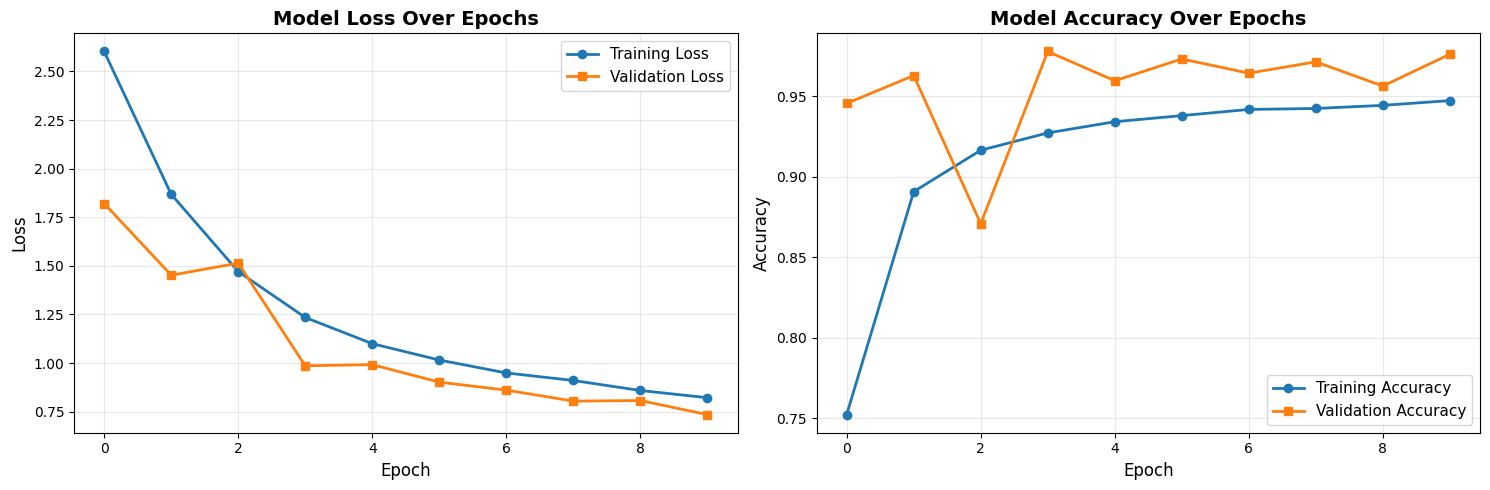

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o')
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
axes[1].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [21]:
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(np.vstack([y for x, y in test_ds]), axis=1)

2514/2514 ━━━━━━━━━━━━━━━━━━━━ 143s 56ms/step


In [22]:
accuracy = np.mean(y_pred == y_true)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\n" + "="*50)
print("EVALUATION METRICS")
print("="*50)
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print("="*50)


EVALUATION METRICS
Accuracy : 0.9762
Precision: 0.9622
Recall   : 0.9790
F1-score : 0.9700


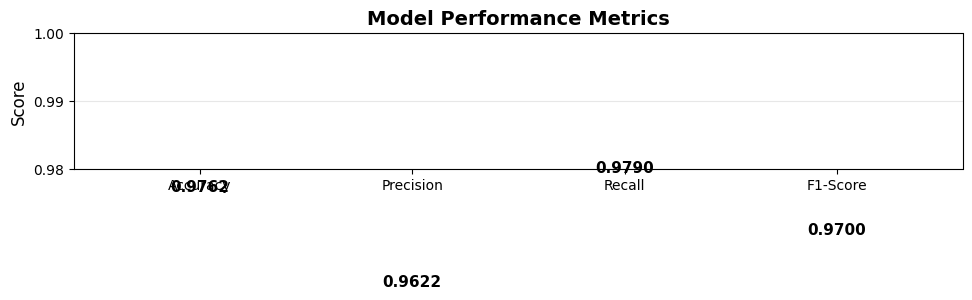

In [23]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors, edgecolor='black', linewidth=2)
plt.ylim([0.98, 1.0])
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [24]:
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred))


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1536
           1       0.96      0.98      0.97       961
           2       1.00      0.93      0.96      2434
           3       0.85      0.98      0.91      1086
           4       0.98      0.98      0.98      1208
           5       0.94      0.99      0.96       229
           6       0.89      0.98      0.93       641
           7       0.98      0.94      0.96       795
           8       0.87      1.00      0.93       212
           9       0.94      0.97      0.95       919
          10       0.98      0.97      0.98       631
          11       0.92      0.99      0.95      1245
          12       0.98      1.00      0.99      2075
          13       0.99      0.98      0.98      1982
          14       1.00      0.97      0.98      5861
          15       0.99      0.98      0.99      2017
          16       0.97      0.96      0.97     

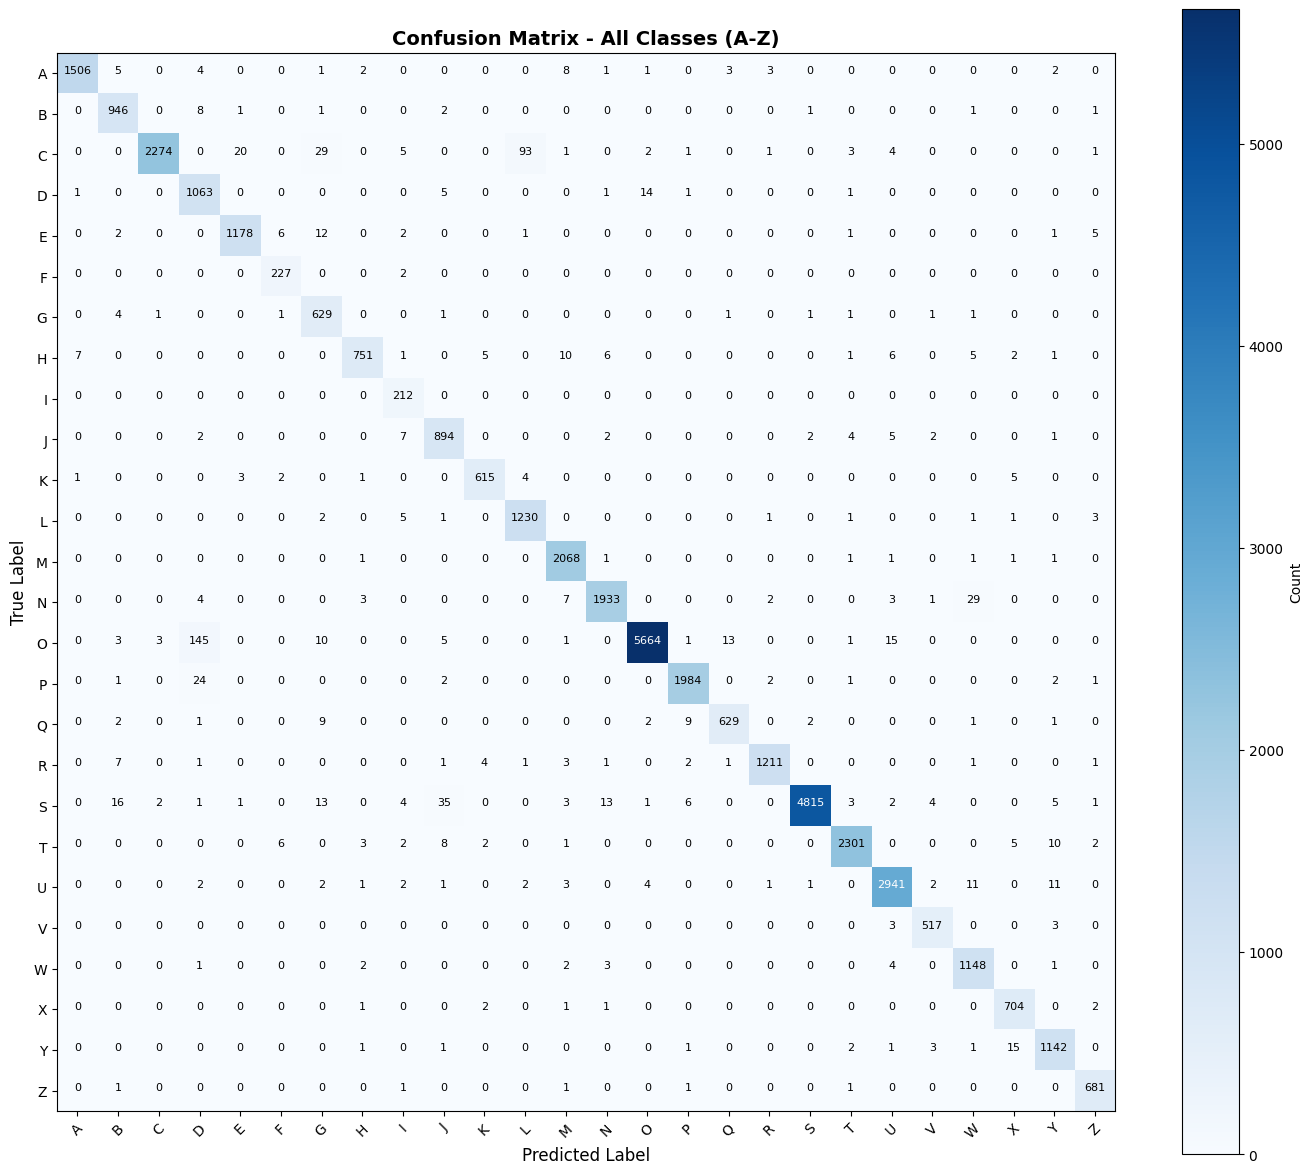

In [25]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix - All Classes (A-Z)", fontsize = 14, fontweight='bold')
plt.colorbar(label='Count')

classes = [chr(i) for i in range(65, 91)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black",
             fontsize=8)

plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.tight_layout()
plt.show()

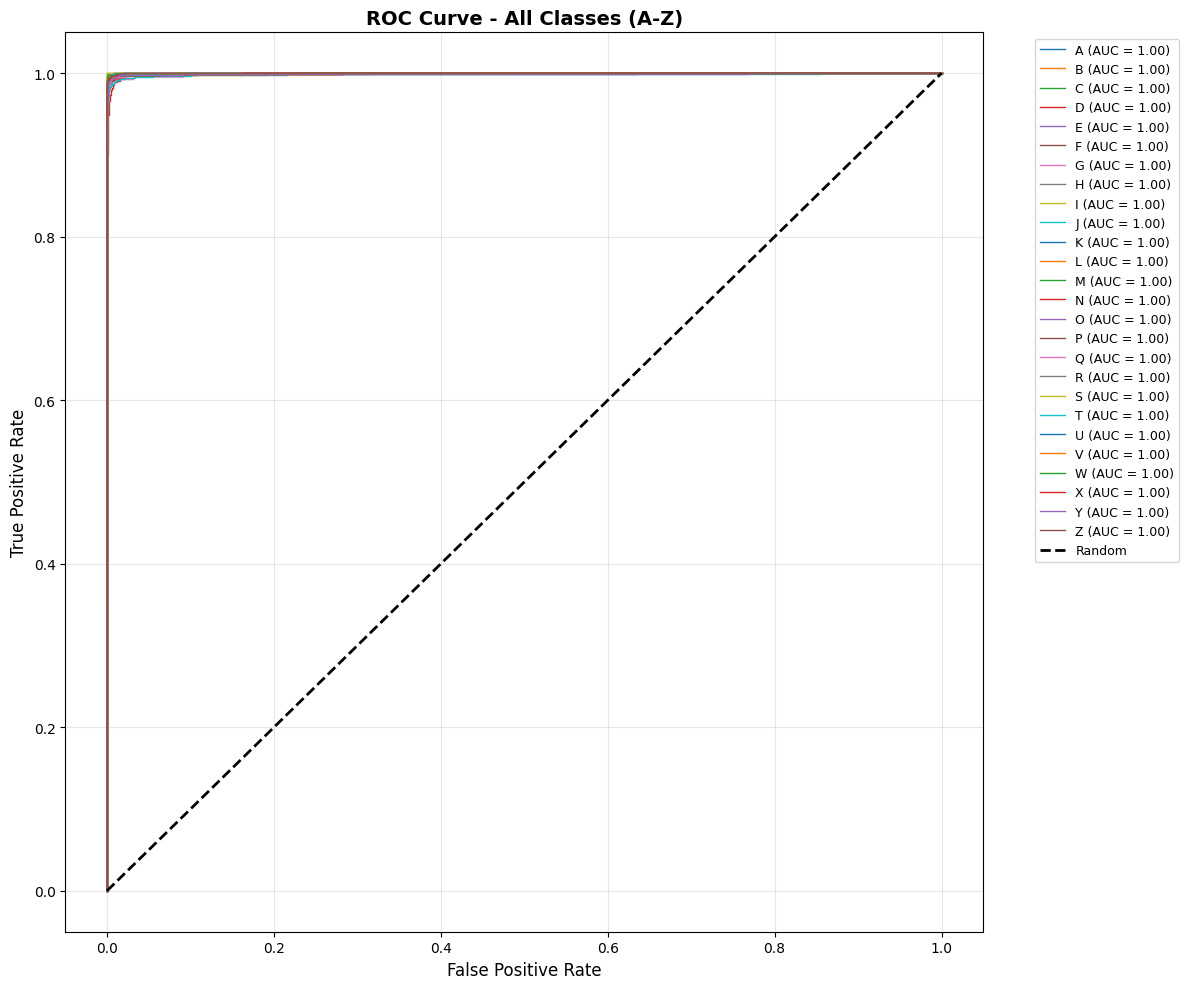

In [26]:
fpr = {}
tpr = {}
roc_auc = {}

y_true_onehot = np.zeros((len(y_true), 26))
for i, label in enumerate(y_true):
    y_true_onehot[i, label] = 1

for i in range(26):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
for i in range(26):
    plt.plot(fpr[i], tpr[i], lw=1, label=f'{chr(65+i)} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Random')
plt.title("ROC Curve - All Classes (A-Z)", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()